In [76]:
from collections import OrderedDict
from copy import deepcopy
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
import torch
import typer
from IPython.display import HTML
from matplotlib import rcParams
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import procrustes
from sklearn.decomposition import PCA
from torch import nn
from torch.utils.data import Subset

from koopmann import aesthetics
from koopmann.aesthetics import ibmplexsans
from koopmann.data import (
    DatasetConfig,
    create_data_loader,
    get_dataset_class,
)
from koopmann.models import MLP, Autoencoder, ExponentialKoopmanAutencoder
from koopmann.models.utils import get_device, pad_act, parse_safetensors_metadata

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
def animate(state_dict, observable_dict, labels, k_steps, ae_dim):
    # Shared marker style based on labels
    colors = [
        aesthetics.SeabornColors.blue if label.item() == 0 else aesthetics.SeabornColors.orange
        for label in labels
    ]
    marker_size = 3

    # Define axis limits and style
    axis_limits = (-0.03, 0.03)

    # Create figure and 3D subplots
    fig = plt.figure(figsize=(12, 7))  # Wider and shorter figure
    ax1 = fig.add_subplot(121, projection="3d")  # Left subplot
    ax2 = fig.add_subplot(122, projection="3d")  # Right subplot

    # Colors
    plt.rcParams["figure.facecolor"] = "#ffffff"
    plt.rcParams["axes.facecolor"] = "#ffffff"
    plt.rcParams["axes.edgecolor"] = "#cccccc"

    # Adjust layout
    fig.subplots_adjust(left=0.05, right=0.95, top=0.88, bottom=0.15, wspace=0.3)

    # Customize both axes
    for ax in [ax1, ax2]:
        ax.set_xlim(axis_limits)
        ax.set_ylim(axis_limits)
        ax.set_zlim(axis_limits)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.grid(False)
        ax.invert_zaxis()  # Flip z-axis

        # Add axis titles
        ax.set_xlabel("PC 1", fontsize=12, font=aesthetics.ibmplexsans, color="#444444", labelpad=2)
        ax.set_ylabel("PC 2", fontsize=12, font=aesthetics.ibmplexsans, color="#444444", labelpad=2)
        ax.set_zlabel("PC 3", fontsize=12, font=aesthetics.ibmplexsans, color="#444444", labelpad=2)

    # Title and subtitle for the entire figure

    fig.suptitle(
        t="Koopman Scaling",
        fontsize=18,
        font=aesthetics.ibmplexsans,
        color="#444444",
        # y=0.97,
    )

    fig.text(
        x=0.5,
        y=0.92,
        s=rf"Lotus root dataset, $k={k_steps}$, $dim={ae_dim}$",
        fontsize=14,
        font=aesthetics.ibmplexsans,
        color="#444444",
        ha="center",
    )
    ax1.set_title("State Space", fontsize=12, color="#444444")
    ax2.set_title("Observable Space", fontsize=12, color="#444444")

    # Initialize scatter plot placeholders with dummy data
    x, y, z = state_dict[0][:, 0], state_dict[0][:, 1], state_dict[0][:, 2]
    scatter1 = ax1.scatter(x, y, z, c=colors, s=marker_size)

    x, y, z = observable_dict[0][:, 0], observable_dict[0][:, 1], observable_dict[0][:, 2]
    scatter2 = ax2.scatter(x, y, z, c=colors, s=marker_size)

    # Add a slider for showing progress
    ax_slider = plt.axes([0.2, 0.05, 0.6, 0.02], facecolor="blue")
    slider = Slider(ax_slider, r"$k$-steps", 0, k_steps - 1, valinit=0, valstep=1)

    # Update function for animation and slider
    def update(frame):
        # Update scatter plot data for both subplots
        scatter1._offsets3d = (
            state_dict[frame][:, 0],
            state_dict[frame][:, 1],
            state_dict[frame][:, 2],
        )

        scatter2._offsets3d = (
            observable_dict[frame][:, 0],
            observable_dict[frame][:, 1],
            observable_dict[frame][:, 2],
        )

        # Update the rotation of the camera
        ax1.view_init(elev=30, azim=frame * (90 / k_steps))  # Rotate camera for ax1
        ax2.view_init(elev=30, azim=frame * (90 / k_steps))  # Opposite rotation for ax2

        # Sync slider value
        slider.set_val(frame)

        return scatter1, scatter2

    def slider_update(val):
        frame = int(slider.val)
        scatter1._offsets3d = (
            state_dict[frame][:, 0],
            state_dict[frame][:, 1],
            state_dict[frame][:, 2],
        )
        scatter2._offsets3d = (
            observable_dict[frame][:, 0],
            observable_dict[frame][:, 1],
            observable_dict[frame][:, 2],
        )

        ax1.view_init(elev=30, azim=frame * (90 / k_steps))  # Rotate camera for ax1
        ax2.view_init(elev=30, azim=frame * (90 / k_steps))  # Opposite rotation for ax2
        fig.canvas.draw_idle()

    slider.on_changed(slider_update)

    # Animation
    ani = FuncAnimation(fig, update, frames=k_steps, interval=100, blit=False)

    return ani


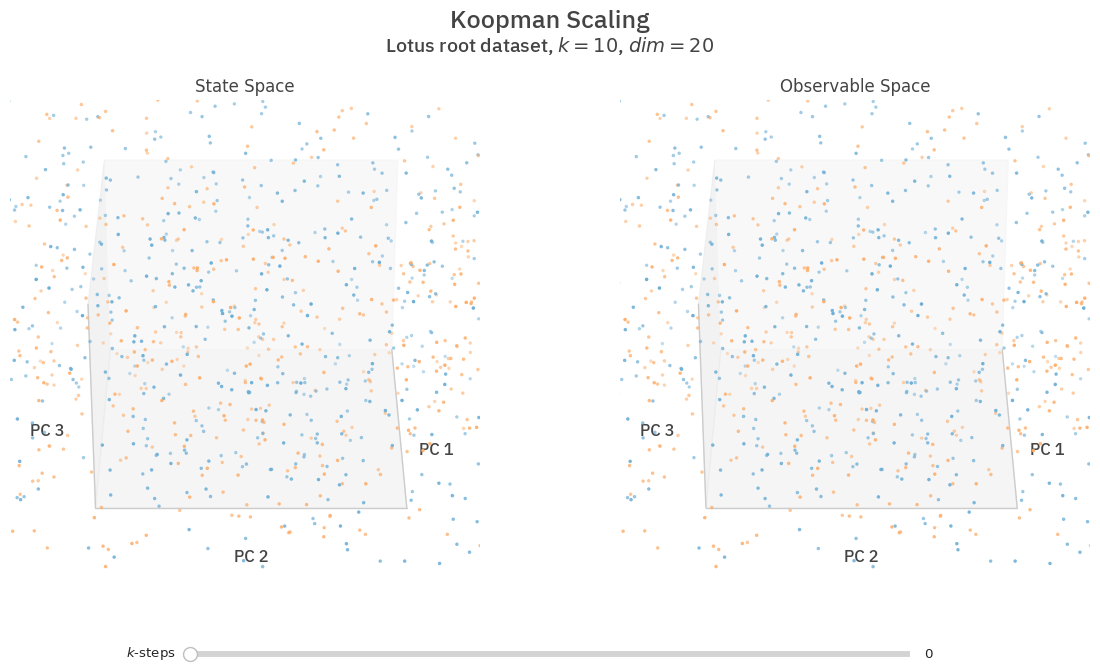

In [78]:
# Create dummy data
def create_dummy_data(num_frames, num_points):
    act_dict = {}
    for frame in range(num_frames):
        # Random data for each frame
        act_dict[frame] = np.random.uniform(-0.05, 0.05, size=(num_points, 3))
    labels = np.random.randint(0, 2, size=num_points)  # Random binary labels
    return act_dict, labels


# Create dummy data
k_steps = 10  # Number of frames
ae_dim = 20
num_points = 1_000  # Number of points in the scatter
act_dict, labels = create_dummy_data(k_steps, num_points)


# Call the animate function and display animation
ani = animate(act_dict, act_dict, labels, k_steps, ae_dim)

# Display the animation in the notebook
ani.save("animated_3d_scatter.gif", writer="pillow")